In [23]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
main_df = pd.read_parquet('updated_main_df2.gzip')
main_df.head()

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,description,online_since,title,med_load_time,load_speed_percentile,category_path,category,rank,indicator,success,unsafe
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,Success,no,google.com,canonical,None,en,2258679.0,Enables users to search the world's informatio...,1997-09-15,Google,1330.0,67.0,None,None,1.0,google.com,True,0.0
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,Success,no,facebook.com,canonical,None,en,4532831.0,"A social utility that connects people, to keep...",1997-03-29,Facebook,3461.0,18.0,None,None,3.0,facebook.com,True,0.0
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,Success,no,youtube.com,canonical,None,en,1771102.0,YouTube is a way to get your videos to the peo...,2005-02-15,YouTube - Broadcast yourself,2852.0,26.0,None,None,2.0,youtube.com,True,0.0
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,Success,no,twitter.com,canonical,None,en,3435448.0,Social networking and microblogging service ut...,2000-01-21,Twitter,1977.0,44.0,None,None,12.0,twitter.com,True,0.0
4,865bce56-288c-48e7-962e-e592f577dd31,Success,no,linkedin.com,canonical,None,en,1254390.0,A networking tool to find connections to recom...,2002-11-02,LinkedIn,2645.0,29.0,None,None,25.0,linkedin.com,True,0.0


In [3]:
bin_df = pd.read_parquet('ft_presence_df.gzip')
bin_df.head()

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,owned_domains,description,...,category_path,category,subdoms,contr_subdom,rank,rank_by_country,use_stats,indicator,success,unsafe
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,1,1,1,1,0,1,1,0,1,...,0,0,1,1,1,1,1,1,1,1
4,865bce56-288c-48e7-962e-e592f577dd31,1,1,1,1,0,1,1,1,1,...,0,0,1,1,1,1,1,1,1,1


In [4]:
#this assumes the two dataframes are lined up and updated_main_df2.gzip and ft_presence_df.gzip should be lined up
#a proper join took to much memory space
main_df = pd.concat([main_df,bin_df.drop(columns = ['requestID','indicator','unsafe'])], axis=1)
main_df

,requestID,status_code,adult_content,url_text,url_type,lang_encoding,lang_locale,links_in_count,description,online_since,...,load_speed_percentile,category_data,category_path,category,subdoms,contr_subdom,rank,rank_by_country,use_stats,success
0,5a473f8d-a2e7-4a98-93f3-f7aa9b73ca96,Success,no,google.com,canonical,None,en,2258679.0,Enables users to search the world's informatio...,1997-09-15,...,1,1,0,0,1,1,1,1,1,1
1,6036b07a-1e9d-4a8a-ae40-938504cfe696,Success,no,facebook.com,canonical,None,en,4532831.0,"A social utility that connects people, to keep...",1997-03-29,...,1,1,0,0,1,1,1,1,1,1
2,5b4446b2-c751-4315-a0d4-c86d8e1d1527,Success,no,youtube.com,canonical,None,en,1771102.0,YouTube is a way to get your videos to the peo...,2005-02-15,...,1,1,0,0,1,1,1,1,1,1
3,f394a37c-3124-4ff8-8e02-2d93c1bbbc45,Success,no,twitter.com,canonical,None,en,3435448.0,Social networking and microblogging service ut...,2000-01-21,...,1,1,0,0,1,1,1,1,1,1
4,865bce56-288c-48e7-962e-e592f577dd31,Success,no,linkedin.com,canonical,None,en,1254390.0,A networking tool to find connections to recom...,2002-11-02,...,1,1,0,0,1,1,1,1,1,1
5,1c03134a-114c-4d7d-b59c-45a731387ade,Success,no,microsoft.com,canonical,None,en,391426.0,"Main site for product information, support, an...",1991-05-02,...,1,1,0,0,1,1,1,1,1,1
6,e4352838-cd77-4a23-b76a-2f2aec88e8e5,Success,None,instagram.com,canonical,None,None,1351380.0,None,NaT,...,1,0,0,0,1,1,1,1,1,1
7,b781ef66-9501-4073-9821-f91034574d41,Success,no,wikipedia.org,canonical,None,en,1237609.0,A free encyclopedia built collaboratively usin...,2001-01-13,...,1,0,1,1,1,1,1,1,1,1
8,3b450de4-28ea-4a05-b00a-602e9003e1c2,Success,no,apple.com,canonical,None,en,296334.0,"Official site, with details of products and se...",NaT,...,1,1,0,0,1,1,1,1,1,1
9,de3b4afd-1998-401b-89c3-926bca9c9e4f,Success,no,google.com,canonical,None,en,2258679.0,Social network that aims to make sharing on th...,1997-09-15,...,1,1,0,0,1,1,1,1,1,1


In [10]:
main_df.columns = list(main_df.columns[:19])+['status_bin','adult_bin','url_text_bin','url_type_bin','encoding_bin', 'locale_bin','links_bin','owned_bin','description_bin','online_bin','title_bin','med_bin','perc_bin', 'catd_bin', 'catp_bin', 'cat_bin', 'subdom_bin', 'contr_bin', 'rank_bin', 'country_rank_bin', 'use_bin', 'success_bin']

In [13]:
main_df['url_text'].value_counts().head(15)

co.cc                  3519
3322.org               1188
beget.tech              573
xsph.ru                 561
google.com              545
securepccleaner.com     535
warzonedns.com          517
zzz.com.ua              464
amazonaws.com           437
tmweb.ru                430
sysinternals.com        412
luyouxia.net            403
security-tls.com        397
flowershame.icu         390
publicvm.com            387
Name: url_text, dtype: int64

In [14]:
main_df=main_df.drop(columns=['category','category_path','url_type'])

In [15]:
#finding edit_distance between url, indicator, and title for last sample taken above
temp = main_df.dropna(subset=['url_text','title','indicator']).reset_index(drop=True)
#temp['title'] = temp['title'].apply(str.lower)
url_to_title = []
for i in range(len(temp['unsafe'])):
    url_to_title.append(nltk.edit_distance(temp['url_text'][i],temp['title'][i]))
url_to_title
temp['url_to_title'] = url_to_title
url_to_ind = []
for i in range(len(temp['unsafe'])):
    url_to_ind.append(nltk.edit_distance(temp['url_text'][i],temp['indicator'][i]))
temp['url_to_ind'] = url_to_ind
title_to_ind = []
for i in range(len(temp['unsafe'])):
    title_to_ind.append(nltk.edit_distance(temp['title'][i],temp['indicator'][i]))
temp['title_to_ind'] = title_to_ind

# save to parquet file - this df gets loaded in the loading block near the top
lev_df = temp.drop(columns=['success','status_code'])
#lev_df.to_parquet('lev_df.gzip',compression = 'gzip')
lev_df[['indicator','url_text','title','url_to_title', 'url_to_ind','title_to_ind']]

,indicator,url_text,title,url_to_title,url_to_ind,title_to_ind
0,google.com,google.com,Google,5,0,5
1,facebook.com,facebook.com,Facebook,5,0,5
2,youtube.com,youtube.com,YouTube - Broadcast yourself,21,0,21
3,twitter.com,twitter.com,Twitter,5,0,5
4,linkedin.com,linkedin.com,LinkedIn,6,0,6
5,microsoft.com,microsoft.com,Microsoft Corporation,12,0,12
6,instagram.com,instagram.com,instagram.com/,1,0,1
7,wikipedia.org,wikipedia.org,Wikipedia,5,0,5
8,apple.com,apple.com,"Apple Computer, Inc.",14,0,14
9,plus.google.com,google.com,Google+,5,5,10


In [16]:
lev_df.to_parquet('lev_df.gzip',compression = 'gzip')

In [20]:
lev_df = pd.read_parquet('lev_df.gzip')

In [21]:
lev_df = lev_df.drop(columns=['requestID','url_text','title','rank','adult_content','lang_encoding','lang_locale','description','online_since','indicator'])#[['requestID','url_to_title','url_to_ind','title_to_ind','rank','links_in_count','load_speed_percentile', 'med_load_time','unsafe']]
#lev_df = lev_df.drop(columns=['rank'])
lev_df = lev_df.dropna()
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(data = scaler.fit_transform(lev_df), columns = lev_df.columns)
#X['requestID'] = lev_df['requestID']
#X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
X0 = X[X['unsafe']==0].sample(frac=1)
print(len(X1))
print(len(X0))
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
    #X1 = X1
else: 
    X0 = X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
    #X0 = X0.reset_index(drop=True)
temp_df = pd.concat([X0,X1]).sample(frac=1).reset_index(drop=True)
#temp_df = temp_df.merge(bin_df.drop(columns=['rank', 'links_in_count','load_speed_percentile', 'med_load_time','indicator','success','unsafe','category','category_path','url_text','url_type','title','status_code'][:1050]), how='inner')
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.60, test_size=0.40, random_state=12)

90692
119752


0.9796014003363013
('links_in_count', 0.37998917388602005)
('med_load_time', 0.10675734029026979)
('load_speed_percentile', 0.0783173450711503)
('status_bin', 0.0)
('adult_bin', 0.014699690156938639)
('url_text_bin', 0.0)
('url_type_bin', 0.0)
('encoding_bin', 0.023426968845661186)
('locale_bin', 0.006581303088479683)
('links_bin', 0.0)
('owned_bin', 0.008100930055028169)
('description_bin', 0.016914708890057417)
('online_bin', 0.011387449661576949)
('title_bin', 0.0)
('med_bin', 0.0)
('perc_bin', 0.0)
('catd_bin', 0.007295105919412921)
('catp_bin', 0.004107643780838113)
('cat_bin', 0.004300655706094785)
('subdom_bin', 0.0)
('contr_bin', 0.04638707393405296)
('rank_bin', 0.0054650458957511685)
('country_rank_bin', 0.028748340418012507)
('use_bin', 0.009351720985557779)
('success_bin', 0.0)
('url_to_title', 0.05851672375860053)
('url_to_ind', 0.13356419927324023)
('title_to_ind', 0.056088580383256786)
             precision    recall  f1-score   support

        0.0       0.97      0.99

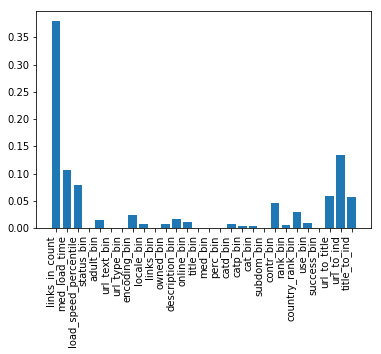

15


In [24]:
forest = RandomForestClassifier(n_estimators=15,min_samples_split = 2,random_state=10)
forest.fit(X_train, Y_train)
print(forest.score(X_test,Y_test))
print(*(list(zip(X.columns,forest.feature_importances_))), sep = '\n')
print(classification_report(Y_test,forest.predict(X_test)))
plt.bar(range(len(X.columns)), forest.feature_importances_)
plt.xticks(range(0,len(X.columns)), X.columns)
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()
print(len(forest.estimators_))

In [26]:
from sklearn.linear_model import LogisticRegression
X = X
Y = Y
#X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.48, test_size=.52,random_state=10)
clf = LogisticRegression(max_iter=100)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(clf.coef_)
print(classification_report(Y_test,clf.predict(X_test)))

0.7515717602654765
[[-1.28258162 -0.11622842  0.46128554  0.          0.42654971  0.
   0.          1.36346787 -1.02780949  0.         -0.20261691 -0.97523198
   0.24592658  0.          0.          0.          0.32440754  0.15452501
   0.15452501  0.         -1.28982692 -0.34417192 -2.60838995  1.14282176
   0.         10.11678033 50.51023063 -1.22410909]]
             precision    recall  f1-score   support

        0.0       0.71      0.84      0.77     47216
        1.0       0.81      0.66      0.73     47105

avg / total       0.76      0.75      0.75     94321



In [27]:
from sklearn.linear_model import LogisticRegressionCV
cv = ShuffleSplit(n_splits=15, test_size=0.4, random_state=10)

#X_train, X_test, Y_train, Y_test = train_test_split(X, np.ravel(Y), train_size=.5, test_size=.5,random_state=10)
clf = LogisticRegressionCV(max_iter=1000,cv=cv,random_state = 10)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(clf.coef_)
print(classification_report(Y_test,clf.predict(X_test)))

0.7713446634365624
[[-1.10030050e+00 -1.80094714e+00  1.57442779e-01  0.00000000e+00
   5.03597557e-01  0.00000000e+00  0.00000000e+00  1.71232387e+00
  -1.30911987e+00  0.00000000e+00 -1.71114747e-01 -8.17295626e-01
   2.60290123e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.21272827e-01  2.20142398e-01  2.20142398e-01  0.00000000e+00
  -1.54364449e+00 -3.79403859e-01 -2.66488476e+00  1.21435730e+00
   0.00000000e+00  3.32490362e+01  3.99360917e+02 -2.92106112e+01]]
             precision    recall  f1-score   support

        0.0       0.72      0.89      0.80     47216
        1.0       0.86      0.65      0.74     47105

avg / total       0.79      0.77      0.77     94321

